In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
import numpy as np
import json
import seaborn as sns

In [2]:
fs = 12
plt.rcParams.update({
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'legend.fontsize': fs
})

In [3]:
wien2k_data = pd.read_csv('/Users/treents/project/aiida-cwf/data/meta-GGA/WIEN2k/summary_pbe_scan_r2scan_r2scan01-2missing.txt', sep='\s+', header=1)
wien2k_data.columns = ['element', 'pbe', 'scan', 'r2scan', 'r2scan01']
wien2k_data = wien2k_data.set_index('element')

with open('/Users/treents/project/aiida-cwf/data/meta-GGA/FHI-aims/R2SCAN_aims.json', 'r') as f:
    fhi_aims_data = json.load(f)
    
fhi_aims_r2scan_volumes = {k: v['min_volume'] for k, v in fhi_aims_data['BM_fit_data'].items()}

In [4]:
def volume_to_lattice_constant(volume, structure_type):
    if structure_type == 'BCC':
        return (2 * volume) ** (1/3)
    elif structure_type == 'FCC':
        return (4 * volume) ** (1/3)
    elif structure_type == 'Diamond':
        return (4 * volume) ** (1/3)
    else:
        raise ValueError("Unknown structure type")

# Example usage:

structure_types = {
    'Ba-X/BCC': 'BCC', 'Cs-X/BCC': 'BCC', 'K-X/BCC': 'BCC', 'Li-X/BCC': 'BCC', 'Mo-X/BCC': 'BCC', 
    'Na-X/BCC': 'BCC', 'Nb-X/BCC': 'BCC', 'Rb-X/BCC': 'BCC', 'Ta-X/BCC': 'BCC', 'V-X/BCC': 'BCC', 
    'W-X/BCC': 'BCC', 'Ag-X/FCC': 'FCC', 'Al-X/FCC': 'FCC', 'Au-X/FCC': 'FCC', 'Ca-X/FCC': 'FCC', 
    'Cu-X/FCC': 'FCC', 'Ir-X/FCC': 'FCC', 'Ni-X/FCC': 'FCC', 'Pd-X/FCC': 'FCC', 'Pt-X/FCC': 'FCC', 
    'Rh-X/FCC': 'FCC', 'Sr-X/FCC': 'FCC', 'C-X/Diamond': 'Diamond', 'Ge-X/Diamond': 'Diamond', 
    'Si-X/Diamond': 'Diamond', 'Sn-X/Diamond': 'Diamond'
}

lattice_constants = {element: volume_to_lattice_constant(volume, structure_types[element]) 
                     for element, volume in fhi_aims_r2scan_volumes.items()}

fhi_aims_df = pd.DataFrame(
    lattice_constants.items(), columns=['element_config', 'fhi_aims_r2scan']
    )
fhi_aims_df['element'] = fhi_aims_df['element_config'].apply(lambda x: x.split('-X')[0])
fhi_aims_df = fhi_aims_df.set_index('element')

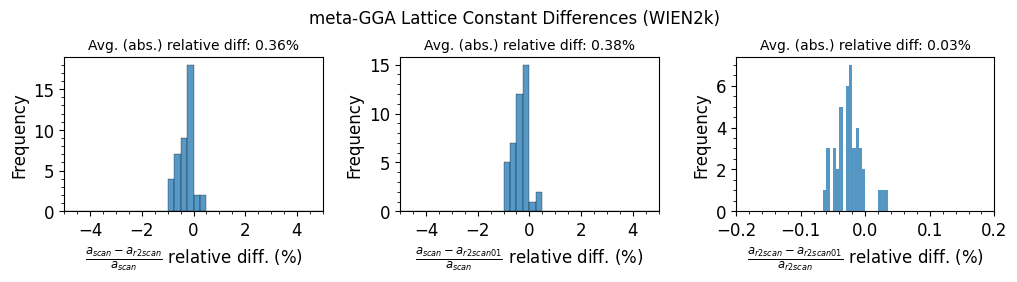

In [16]:
diff_labels = list(combinations(wien2k_data.drop('pbe', axis=1).columns, 2))

# Create subplots for relative differences
fig, axes = plt.subplots(nrows=len(diff_labels)//3, ncols=3, figsize=(12, 2.5*len(diff_labels)//3))
plt.subplots_adjust(hspace=0.45, wspace=0.3)

# Plot each column in a separate subplot
for ax, labs in zip(axes.flatten(), diff_labels):
    relative_diff = (wien2k_data[labs[0]] - wien2k_data[labs[1]]) / wien2k_data[labs[0]] * 100
    bins = np.arange(-10, 10, 0.25)
    if 'r2scan' in labs and 'r2scan01' in labs:
        bins = np.arange(-5, 5, 0.005)
    sns.histplot(relative_diff, bins=bins, ax=ax)
    # ax.set_title(f'Relative Difference of {col}')
    ax.set_xlabel(f'$\\frac{{a_{{{labs[0]}}} - a_{{{labs[1]}}}}}{{a_{{{labs[0]}}}}}$ relative diff. (%)')
    ax.yaxis.get_major_locator().set_params(integer=True, nbins=5)
    ax.minorticks_on()
    ax.set_ylabel('Frequency')
    ax.set_xlim(-5, 5)
    if 'r2scan' in labs and 'r2scan01' in labs:
        ax.set_xlim(-.2, .2)
    ax.set_title(f'Avg. (abs.) relative diff: {relative_diff.abs().mean():.2f}%', fontsize=10)

# plt.tight_layout()
plt.suptitle('meta-GGA Lattice Constant Differences (WIEN2k)', y=1.12)
plt.savefig('meta_gga_a0_diff.png', bbox_inches='tight')

## Compare WIEN2k and fhi_aims

In [6]:
df_wien2k_fhi_aims = pd.merge(wien2k_data, fhi_aims_df, left_index=True, right_index=True, how='inner')
df_wien2k_fhi_aims.head(2)

,pbe,scan,r2scan,r2scan01,element_config,fhi_aims_r2scan
element,,,,,,
Ag,4.1478,4.0823,4.1045,4.1068,Ag-X/FCC,4.104916
Al,4.0407,4.0119,3.9953,3.9958,Al-X/FCC,3.995455


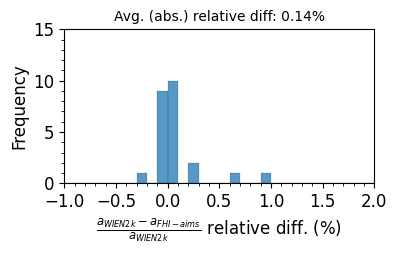

In [7]:
fig, ax = plt.subplots(figsize=(4, 2))

wien2k_fhi_aims_r2scan_rel_diff = (
    df_wien2k_fhi_aims['r2scan'] - df_wien2k_fhi_aims['fhi_aims_r2scan']
) / df_wien2k_fhi_aims['r2scan'] * 100

_ = sns.histplot(wien2k_fhi_aims_r2scan_rel_diff, bins=np.arange(-10, 10, 0.1), ax=ax)
ax.set_xlabel('$\\frac{{a_{WIEN2k} - a_{FHI-aims}}}{{a_{WIEN2k}}}$ relative diff. (%)')
ax.yaxis.get_major_locator().set_params(integer=True, nbins=5)
ax.minorticks_on()
ax.set_ylabel('Frequency')
ax.set_xlim(-1, 2)
ax.set_ylim(0, 15)
ax.set_title(f'Avg. (abs.) relative diff: {wien2k_fhi_aims_r2scan_rel_diff.abs().mean():.2f}%', fontsize=10)
plt.savefig('wien2k_fhi_aims_r2scan_diff.png', bbox_inches='tight')

In [8]:
df_wien2k_fhi_aims

,pbe,scan,r2scan,r2scan01,element_config,fhi_aims_r2scan
element,,,,,,
Ag,4.1478,4.0823,4.1045,4.1068,Ag-X/FCC,4.104916
Al,4.0407,4.0119,3.9953,3.9958,Al-X/FCC,3.995455
Au,4.1585,4.0950,4.1253,4.1273,Au-X/FCC,4.125956
Ba,5.0219,5.0783,5.0694,5.0709,Ba-X/BCC,5.074215
Ca,5.5277,5.5389,5.5667,5.5676,Ca-X/FCC,5.570653
C,3.5715,3.5532,3.5596,3.5597,C-X/Diamond,3.558529
Cs,6.1611,6.2201,6.2756,6.2741,Cs-X/BCC,6.214891
Cu,3.6289,3.5569,3.5753,3.5768,Cu-X/FCC,3.573193
Ge,5.7611,5.6671,5.6780,5.6802,Ge-X/Diamond,5.672421
